In [73]:
import numpy as np
import zipfile
import pickle
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from PIL import Image
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Download and unzip
dataroot = "/kaggle/input/trafficsigns/"
# dataroot = "/home/aakarsh/comp4449/material/3_MidtermProjects/ProjectRTS/data/"
# !mkdir dataroot 
# !wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
# !wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
# !wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip 

In [ ]:
# # Unzip
# with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
#     zip_ref.extractall(dataroot)
# with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
#     zip_ref.extractall(dataroot)
# with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
#     zip_ref.extractall(dataroot)

In [3]:
# Load sign names
import pandas as pd
# df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
# df = pd.read_csv("/home/aakarsh/comp4449/material/3_MidtermProjects/ProjectRTS/data/signnames.csv")
df = pd.read_csv("/kaggle/input/trafficsigns/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
signnames

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

In [4]:
# Load images

signimages = pickle.load( open( dataroot+"train.p", "rb" ) )

signimages_valid = pickle.load(open(dataroot+"valid.p", "rb"))

signimages_test = pickle.load(open(dataroot+"test.p", "rb"))

The image shows a Turn left ahead sign


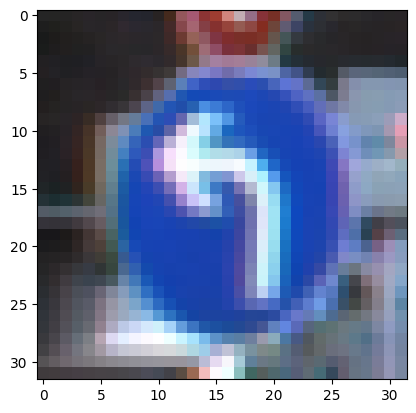

In [5]:
# Preview image
inx = 20123
plt.imshow(signimages['features'][inx])
print("The image shows a {} sign".format(signnames[signimages['labels'][inx]]))

## Preprocessing the dataset

In [6]:
# len(signimages['coords'])

# function to resize the images and append them into an array, extract the labels from the images into another numpy array for all 3 datasets 
def preprocess_signs(images):
    x = []
    for feature in images['features']:
        pict = Image.fromarray(feature).resize((32,32))
        x.append(np.array(pict))
    # 43 different traffic signs, so we one-hot encode the labels
    y = tf.keras.utils.to_categorical(images['labels'], 43)
    return x,y

x_train,y_train = preprocess_signs(signimages)
x_valid, y_valid = preprocess_signs(signimages_valid)
x_test, y_test = preprocess_signs(signimages_test)

In [7]:
x_train[0].shape

(32, 32, 3)

In [127]:
x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test = np.array(x_test)

train_labels = np.argmax(y_train, axis =1)
valid_labels = np.argmax(y_valid, axis =1)
test_labels = np.argmax(y_test, axis = 1)

print("Shape of x_train array:", x_train.shape)
print("Shape of x_valid array:", x_valid.shape)
print("Shape of x_test array:", x_test.shape)


print("\nShape of y_train array:", y_train.shape)
print("Shape of y_valid array:", y_valid.shape)
print("Shape of y_test array:", y_test.shape)

Shape of x_train array: (34799, 32, 32, 3)
Shape of x_valid array: (4410, 32, 32, 3)
Shape of x_test array: (12630, 32, 32, 3)

Shape of y_train array: (34799, 43)
Shape of y_valid array: (4410, 43)
Shape of y_test array: (12630, 43)


## Functions

In [126]:
def histogram_plot(train_labels, valid_labels, test_labels):
    sign_names = [signnames[i] for i in range(43)]

    plt.figure(figsize=(16,12))
    plt.hist([train_labels, valid_labels, test_labels], bins= np.arange(44)-0.5, alpha = 0.7, color=['blue', 'green', 'orange'], 
             edgecolor = 'black', stacked=True, label=['Training', 'Validation', 'Testing'])
    
    plt.title('Distribution of traffic sign classes across Datasets')
    plt.xlabel('Sign Class')
    plt.ylabel('Image count')
    plt.xticks(range(43), sign_names, rotation=90, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc = 'best')
    plt.tight_layout()
    plt.show()

In [17]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18, 10)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])
  
  plt.tight_layout()
  return plt.show()

In [103]:
def get_actual_labels(data, y, model):
    actual = np.argmax(y, axis=1)
    predicted = model.predict(data)
    predicted = np.argmax(predicted, axis=1)

    return actual, predicted

In [117]:
# A classification report on sign prediction accuracy
# if there were incorrect predictions, it shows what the incorrect prediction was,
# and how many signs it incorrectly predicted

def class_report_incorrect(confuse_matrix, signs):
    class_labels = [i for i in range(confusion_mat.shape[0])]


    class_acc = confuse_matrix.diagonal()/confuse_matrix.sum(axis=1) * 100 
    cls_acc_df = pd.DataFrame({'Class_Label':[class_labels[i] for i in range(43)], 'Accuracy': class_acc.tolist()}, columns = ['Class_Label', 'Accuracy'])


    incorrect_predictions = []

    # incorrect predictions
    for true_label in range(confuse_matrix.shape[0]):
        for pred_label in range(confuse_matrix.shape[1]):
            if true_label != pred_label and confuse_matrix[true_label, pred_label] > 0:
                incorrect_predictions.append({
                    "True_Label": class_labels[true_label],
                    "Predicted_Label": class_labels[pred_label],
                    "Count": confuse_matrix[true_label, pred_label]
                })

    incorrect_df = pd.DataFrame(incorrect_predictions)

    class_acc_incorrect_df = pd.merge(cls_acc, incorrect_df, left_on='Class_Label', right_on='True_Label', how='left')


    # Drop redundant columns
    class_acc_incorrect_df.drop(columns=['True_Label'], inplace=True)

    # currently shows only the label numbers. so mapping the names using the signnames series
    class_acc_incorrect_df['Class_Label'] = class_acc_incorrect_df['Class_Label'].map(signs)
    class_acc_incorrect_df['Predicted_Label'] = class_acc_incorrect_df['Predicted_Label'].map(signs)
    class_acc_incorrect_df = class_acc_incorrect_df.style.set_properties(**{'index': False})

    return class_acc_incorrect_df.format({"Accuracy": "{:,.2f}%", "Count": "{:,.0f}"})
    

In [118]:
def show_signs_output(model, signs, data,labels):
    random_test_indices = random.sample(range(len(data)), 12)

    figure, axes = plt.subplots(6,2, figsize = (25,25))

    for x, ax in enumerate(axes.flat):
        random_image = random_test_indices[x]
        actual_label = np.argmax(labels[random_image])
        predicted_label = np.argmax(model.predict(data[random_image].reshape(1, 32, 32, 3)))
        sign_name = signs[actual_label]
        ax.imshow(data[random_image].astype('uint8'))
        ax.grid(False)
        ax.axis('off')
        ax.set_title('Name of sign: {}\nActual: {}\nPredicted: {}'.format(sign_name, actual_label, predicted_label))
        plt.tight_layout()

## Visualization of datasets

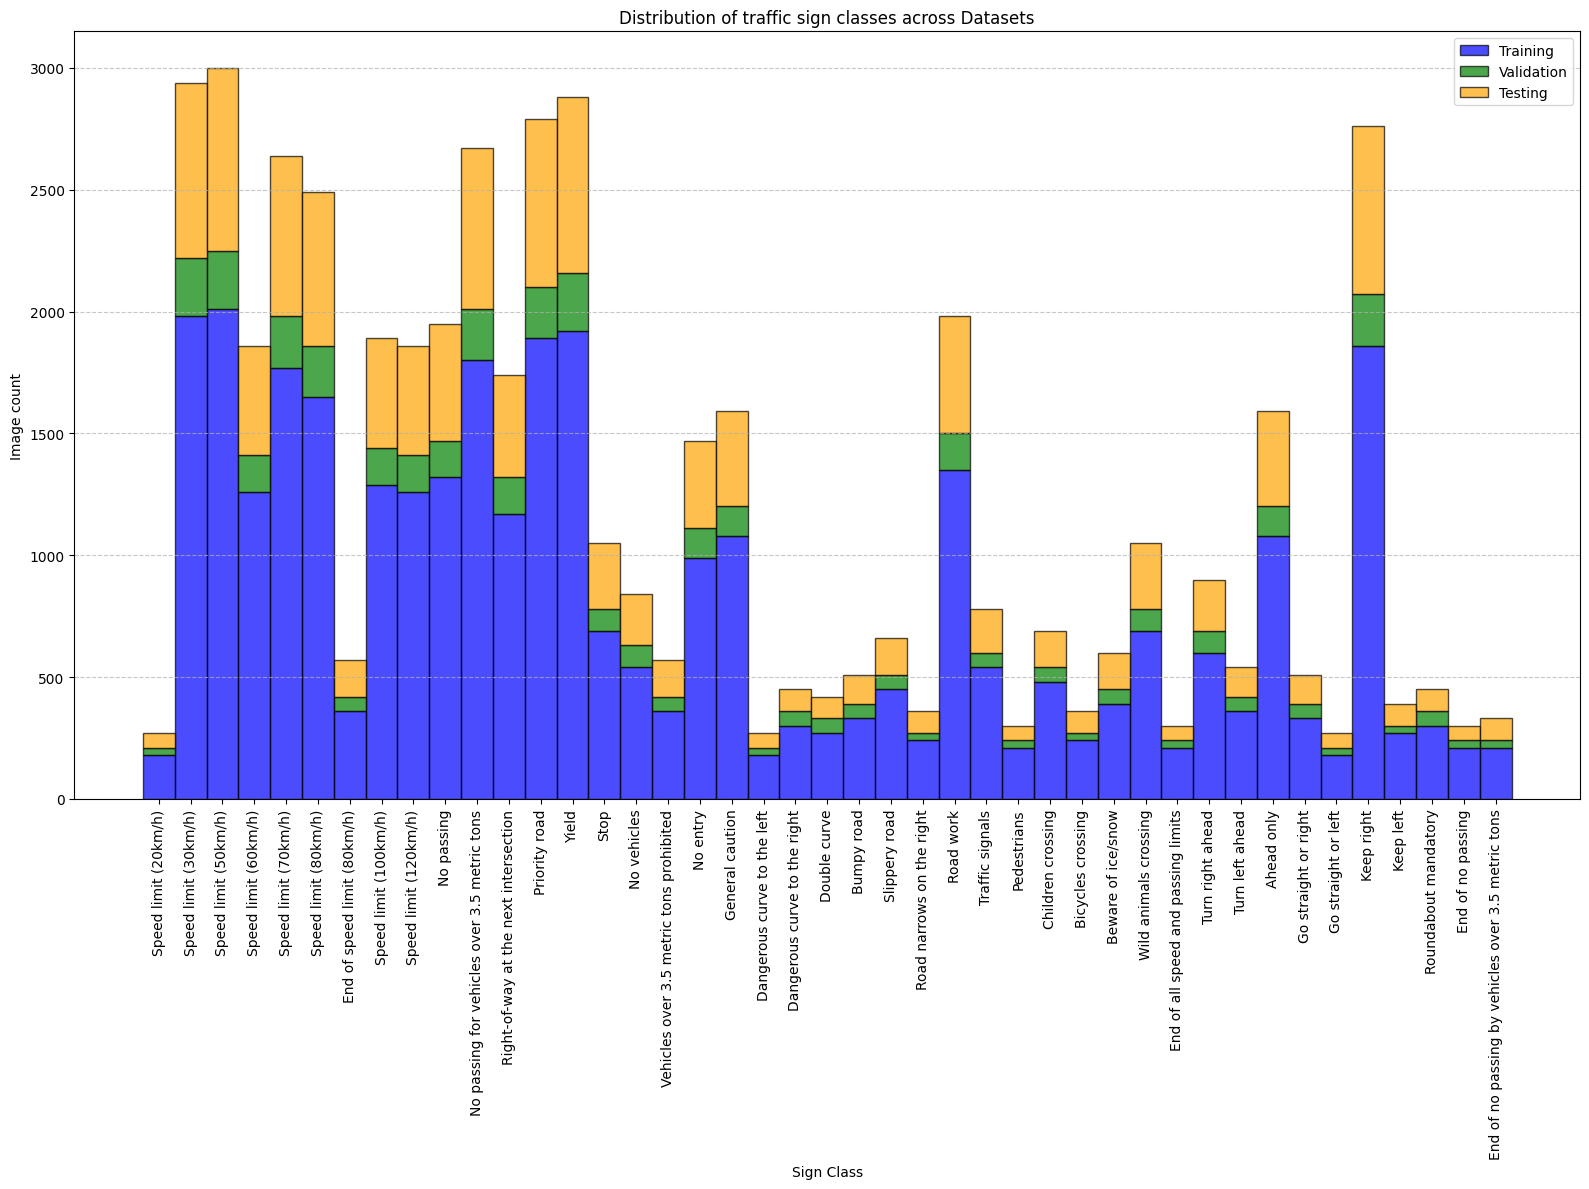

In [125]:
histogram_plot(train_labels,valid_labels,test_labels)

## Using a 3 block CNN model

### A simple implementation of CNN to use as a baseline model against later improved models

In [99]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.25),
    
    tf.keras.layers.Conv2D(100, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.5),
    
    tf.keras.layers.Conv2D(150, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.25),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(300, activation='relu'),
    
    tf.keras.layers.Dense(100, activation='relu'),
    
    tf.keras.layers.Dense(43, activation='softmax') # output layer 43 neurons for 43 classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 100)    │        28,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 6, 6, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 6, 100)      │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 6, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 150)      │       135,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 2, 2, 150)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 150)      │           600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 2, 150)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 300)            │       180,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 43)             │         4,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380,817 (1.45 MB)

 Trainable params: 380,253 (1.45 MB)

 Non-trainable params: 564 (2.20 KB)

In [100]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_valid, y_valid))

Epoch 1/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.5103 - loss: 1.7625 - val_accuracy: 0.9200 - val_loss: 0.2830
Epoch 2/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9314 - loss: 0.2091 - val_accuracy: 0.9467 - val_loss: 0.2038
Epoch 3/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9594 - loss: 0.1308 - val_accuracy: 0.9512 - val_loss: 0.1770
Epoch 4/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9680 - loss: 0.0980 - val_accuracy: 0.9621 - val_loss: 0.1572
Epoch 5/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9729 - loss: 0.0830 - val_accuracy: 0.9580 - val_loss: 0.1566
Epoch 6/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9746 - loss: 0.0841 - val_accuracy: 0.9730 - val_loss: 0.1046
Epoch 7/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9795 - loss: 0.0649 - val_accuracy: 0.9669 - val_loss: 0.1410
Epoch 8/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9827 - loss: 0.0563 

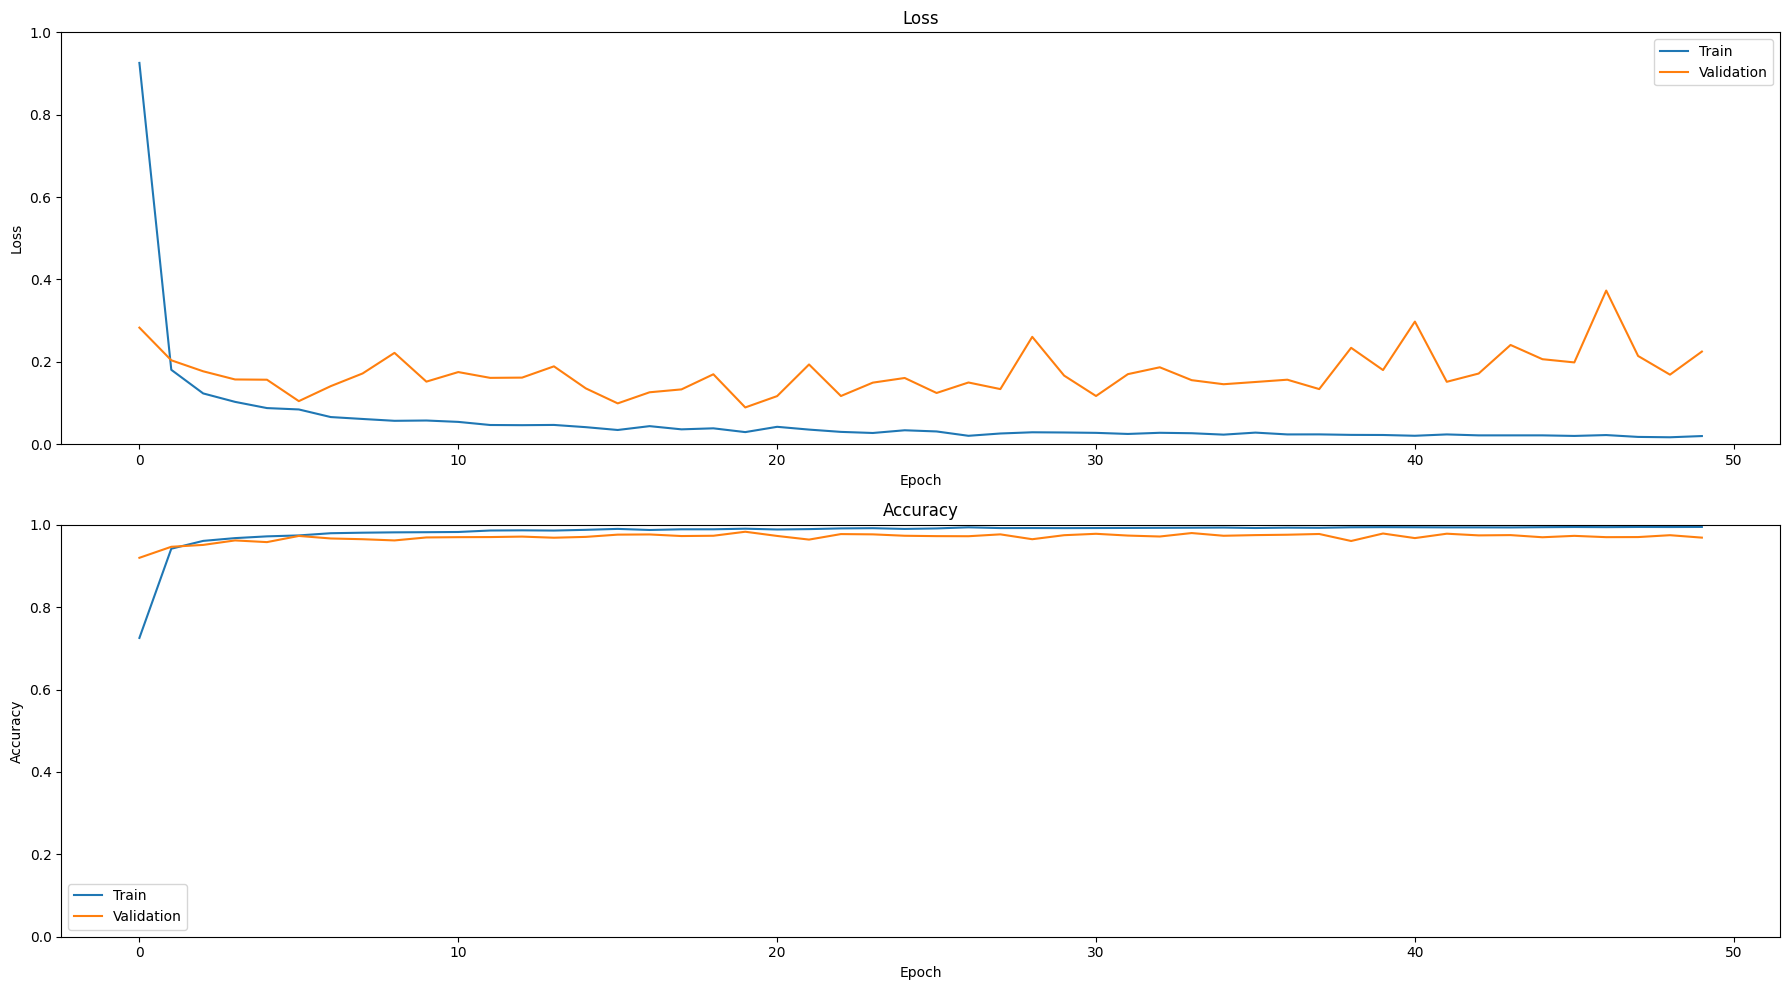

In [101]:
plot_history(history)

#### The model has good training & validation accuracy readings, but the **validation loss** does not stabilize and increases over the epochs

## Pre-trained Model: Resnet50V2
### Weights = imagenet, layers.trainable = False
### Image Augmentation : No
### Early stops, dropouts, learning rate scheduler : No, No, Yes

In [93]:
resnet_base_untrain = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
resnet_base_untrain.trainable = False

resnet_base_untrain.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_9[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [89]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-4)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath="resnet_without_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")]

# Create the model
inputs3 = tf.keras.Input(shape=(32, 32, 3))
x = inputs3
x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = resnet_base_untrain(x)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
dense_outputs3 = tf.keras.layers.Dense(43, activation='softmax')(x)
resnet_model_untrain = tf.keras.models.Model(inputs=inputs3, outputs=dense_outputs3)

resnet_model_untrain.compile(
    optimizer="adam", 
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [91]:
large_model_history_untrain = resnet_model_untrain.fit(
    x_train,y_train,
    epochs=30,
    validation_data=(x_valid,y_valid),
    batch_size = 32, callbacks=[lr_scheduler, callbacks]
)

Epoch 1/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6440 - loss: 1.1505

W0000 00:00:1714593546.124064     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.6440 - loss: 1.1504 - val_accuracy: 0.3769 - val_loss: 2.5081 - learning_rate: 0.0010
Epoch 2/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7313 - loss: 0.8615 - val_accuracy: 0.3728 - val_loss: 2.7887 - learning_rate: 0.0010
Epoch 3/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7900 - loss: 0.6841 - val_accuracy: 0.3707 - val_loss: 2.9689 - learning_rate: 0.0010
Epoch 4/30
1086/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8246 - loss: 0.5697
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8246 - loss: 0.5697 - val_accuracy: 0.3608 - val_loss: 3.3020 - learning_rate: 0.0010
Epoch 5/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8798 - loss: 0.4265 - val_accuracy: 0.3766 - val_loss: 3.2624 - learning_rate: 1.0000e-04
Epoch 6/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9003 - loss: 

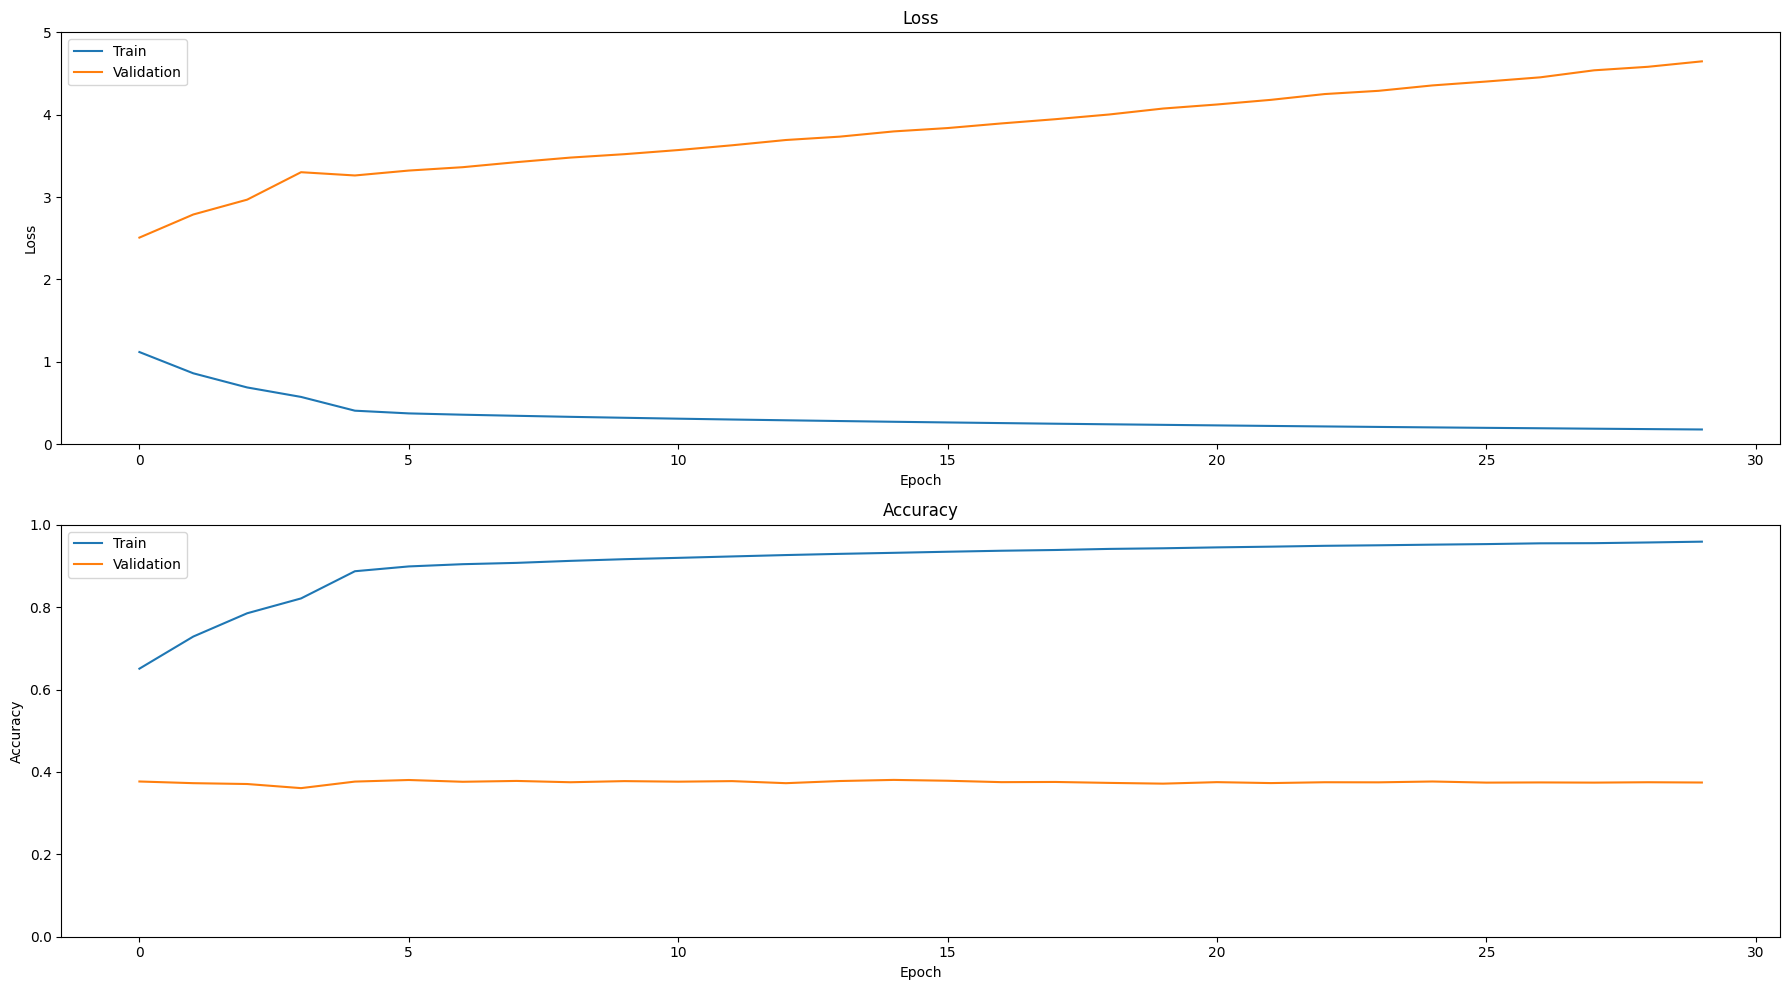

In [94]:
plot_history(large_model_history_untrain)

# there are clear signs of overfitting without any image augmentation.

## Pre-trained Model: Resnet50V2
### Weights = imagenet, layers.trainable = Only the last 10 layers are frozen
### Image Augmentation : Yes
### learning rate scheduler : Yes

In [96]:
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2)
])


resnet_base_new = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
resnet_base_new.trainable = True

for layer in resnet_base_new.layers[:-10]:
    layer.trainable = False
    
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Create the model
inputs2 = tf.keras.Input(shape=(32, 32, 3))
x = data_augment(inputs2)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = resnet_base_new(x)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(100, activation = 'relu')(x)
dense_outputs2 = tf.keras.layers.Dense(43, activation='softmax')(x)
resnet_model_3 = tf.keras.models.Model(inputs=inputs2, outputs=dense_outputs2)

resnet_model_3.compile(
    optimizer=optimizer, 
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [97]:
large_model_history_4 = resnet_model_3.fit(
    x_train,y_train,
    epochs=30,
    validation_data=(x_valid,y_valid),
    batch_size = 32
)

Epoch 1/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.1792 - loss: 3.1688 - val_accuracy: 0.3202 - val_loss: 2.4594
Epoch 2/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.3776 - loss: 2.1165 - val_accuracy: 0.3599 - val_loss: 2.3015
Epoch 3/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.4310 - loss: 1.8899 - val_accuracy: 0.3549 - val_loss: 2.2999
Epoch 4/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.4593 - loss: 1.7611 - val_accuracy: 0.3787 - val_loss: 2.2317
Epoch 5/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.4798 - loss: 1.6717 - val_accuracy: 0.3669 - val_loss: 2.3133
Epoch 6/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.5005 - loss: 1.5988 - val_accuracy: 0.3875 - val_loss: 2.2498
Epoch 7/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.5172 - loss: 1.5540 - val_accuracy: 0.3776 - val_loss: 2.3158
Epoch 8/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.5308 -

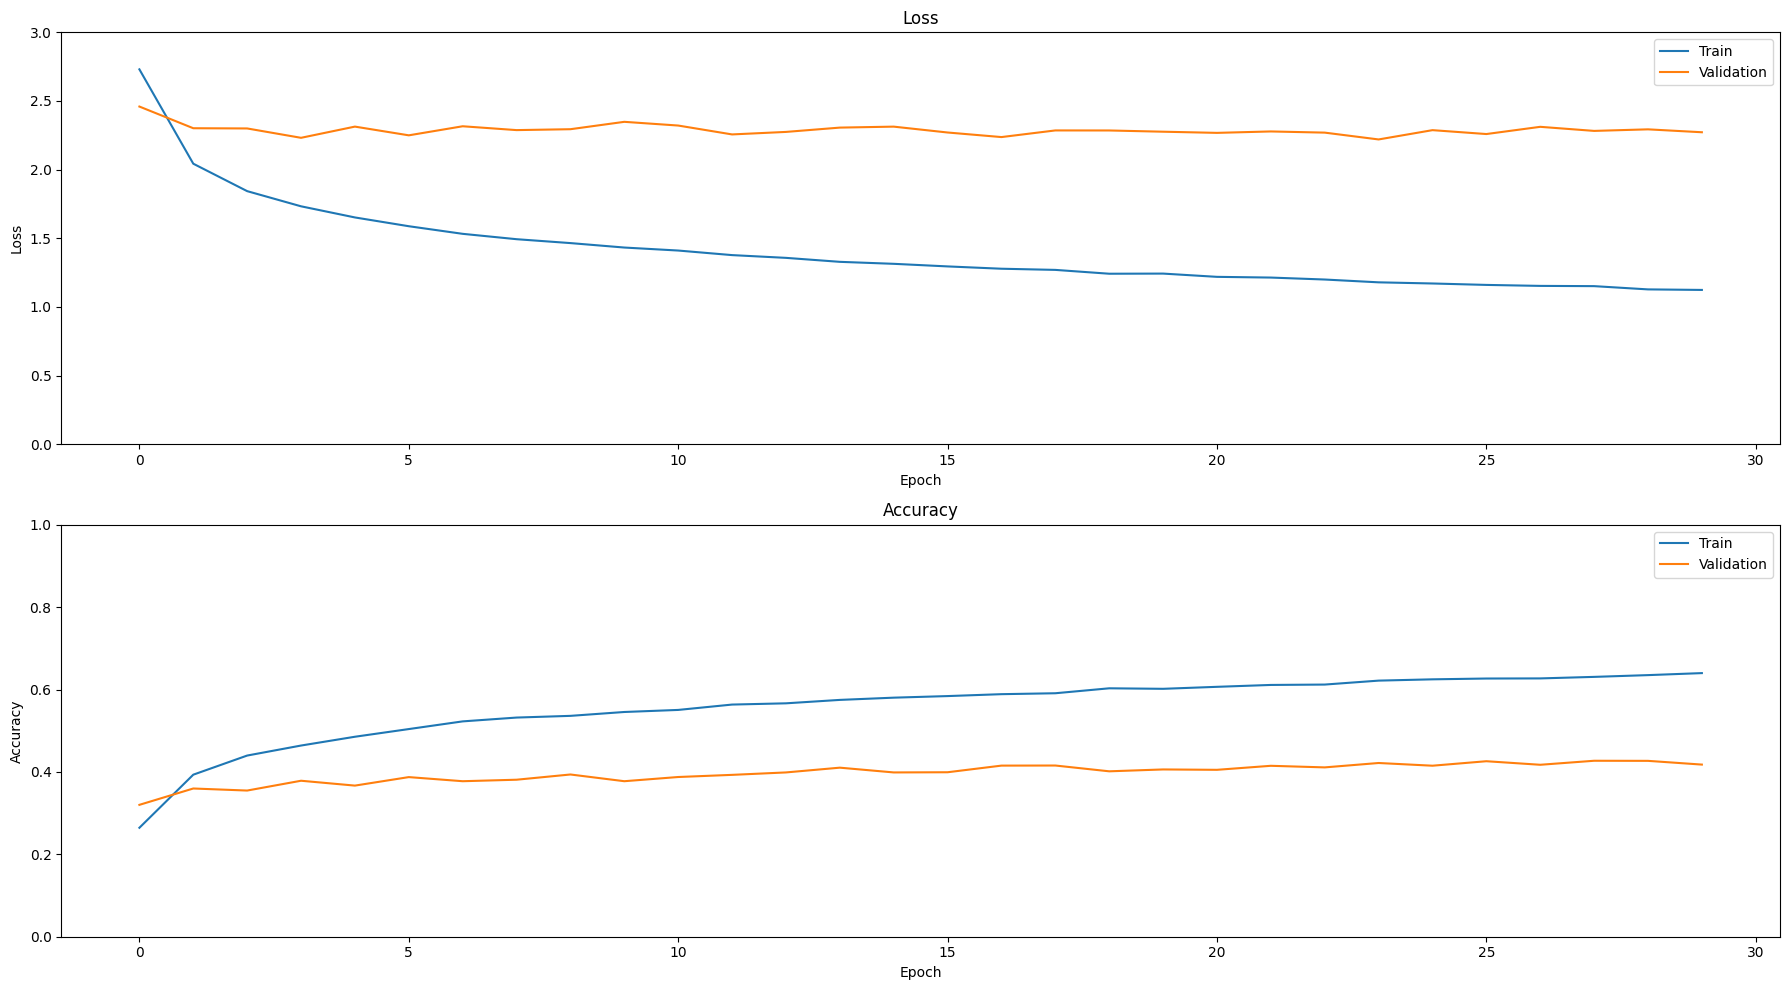

In [98]:
plot_history(large_model_history_4)

# model has bad accuracy and loss metrics

## Pre-trained Model: Resnet50V2
### Weights = None, layers.trainable = True
### Image Augmentation : No
### Early stops, dropouts, learning rate scheduler : Yes

In [ ]:
resnet_base_nda = tf.keras.applications.ResNet50V2(weights=None, include_top=False, input_shape=(32, 32, 3))
# resnet_base_nda.trainable = False

resnet_base_nda.summary()

Model: "resnet50v2"

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [81]:
# Create the model
x = resnet_base_nda.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2048, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation = "relu")(x)
output_layer = tf.keras.layers.Dense(43, activation = "softmax")(x)

resnet_modified = tf.keras.models.Model(resnet_base_nda.input, outputs = output_layer)


In [82]:
resnet_modified.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 8, 8, 64)  │          0 │ conv2_block1_pre… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 10, 10,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 8, 8, 256) │          0 │ conv2_block1_0_c

 Total params: 28,832,299 (109.99 MB)

 Trainable params: 28,786,859 (109.81 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [83]:
resnet_modified.compile(optimizer ="adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [84]:
model_check = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

early_stops = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)


In [85]:
resnet_history = resnet_modified.fit(x_train,y_train,epochs=30,validation_data=(x_valid,y_valid),
                                     batch_size = 32, callbacks=[early_stops, model_check,lr_scheduler])

Epoch 1/30
   1/1088 ━━━━━━━━━━━━━━━━━━━━ 17:35:23 58s/step - accuracy: 0.0312 - loss: 3.9319

I0000 00:00:1714591859.177491     134 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714591859.257048     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8349 - loss: 0.7456

W0000 00:00:1714591919.125379     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714591922.815492     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 129s 65ms/step - accuracy: 0.8350 - loss: 0.7452 - val_accuracy: 0.8501 - val_loss: 0.9555 - learning_rate: 0.0010
Epoch 2/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - accuracy: 0.9544 - loss: 0.1697 - val_accuracy: 0.9113 - val_loss: 0.4479 - learning_rate: 0.0010
Epoch 3/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.9612 - loss: 0.1405 - val_accuracy: 0.8558 - val_loss: 0.8470 - learning_rate: 0.0010
Epoch 4/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - accuracy: 0.9679 - loss: 0.1321 - val_accuracy: 0.9186 - val_loss: 0.4773 - learning_rate: 0.0010
Epoch 5/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.9784 - loss: 0.0932 - val_accuracy: 0.8787 - val_loss: 0.6588 - learning_rate: 0.0010
Epoch 6/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - accuracy: 0.9706 - loss: 0.1246 - val_accuracy: 0.9222 - val_loss: 0.3992 - learning_rate: 0.0010
Epoch 7/30
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - accuracy: 0.9813

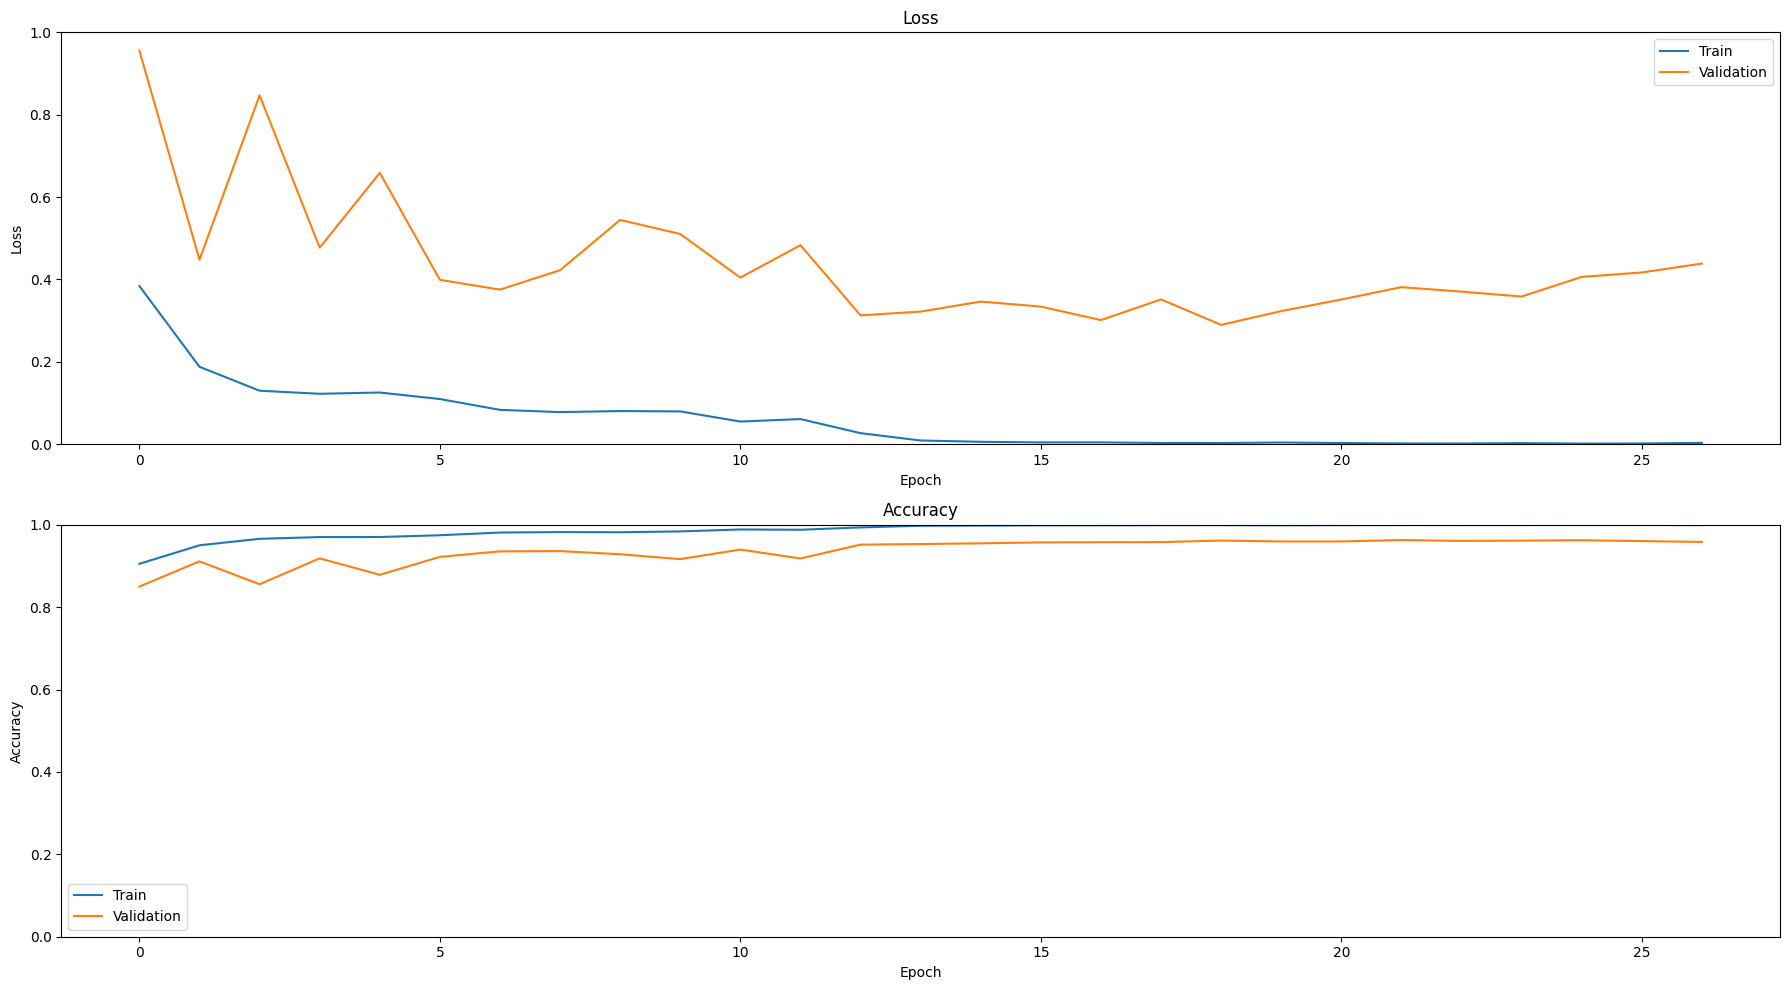

In [86]:
plot_history(resnet_history)

# there are clear signs of overfitting without any image augmentation.

In [106]:
#Testing on the non-augmented data resnet model
actual_noaug, predicted_noaug = get_actual_labels(x_test,y_test,resnet_modified)
label_names = [signnames[i] for i in range(len(signnames))]
class_report_noaug = classification_report(actual, predicted, target_names=label_names)
print(class_report_noaug)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.90      0.90      0.90        60
                              Speed limit (30km/h)       0.92      0.98      0.95       720
                              Speed limit (50km/h)       0.93      0.97      0.95       750
                              Speed limit (60km/h)       0.98      0.96      0.97       450
                              Speed limit (70km/h)       0.97      0.93      0.95       660
                              Speed limit (80km/h)       0.90      0.92      0.91       630
                       End of speed limit (80km/h)       0.99      0.81      0.89       150
                             Speed limit (100km/h)       0.98      0.90      0.94       450
                             Speed limit (120km/h)       0.95      0.96      0.96       450
                                      

<Axes: >

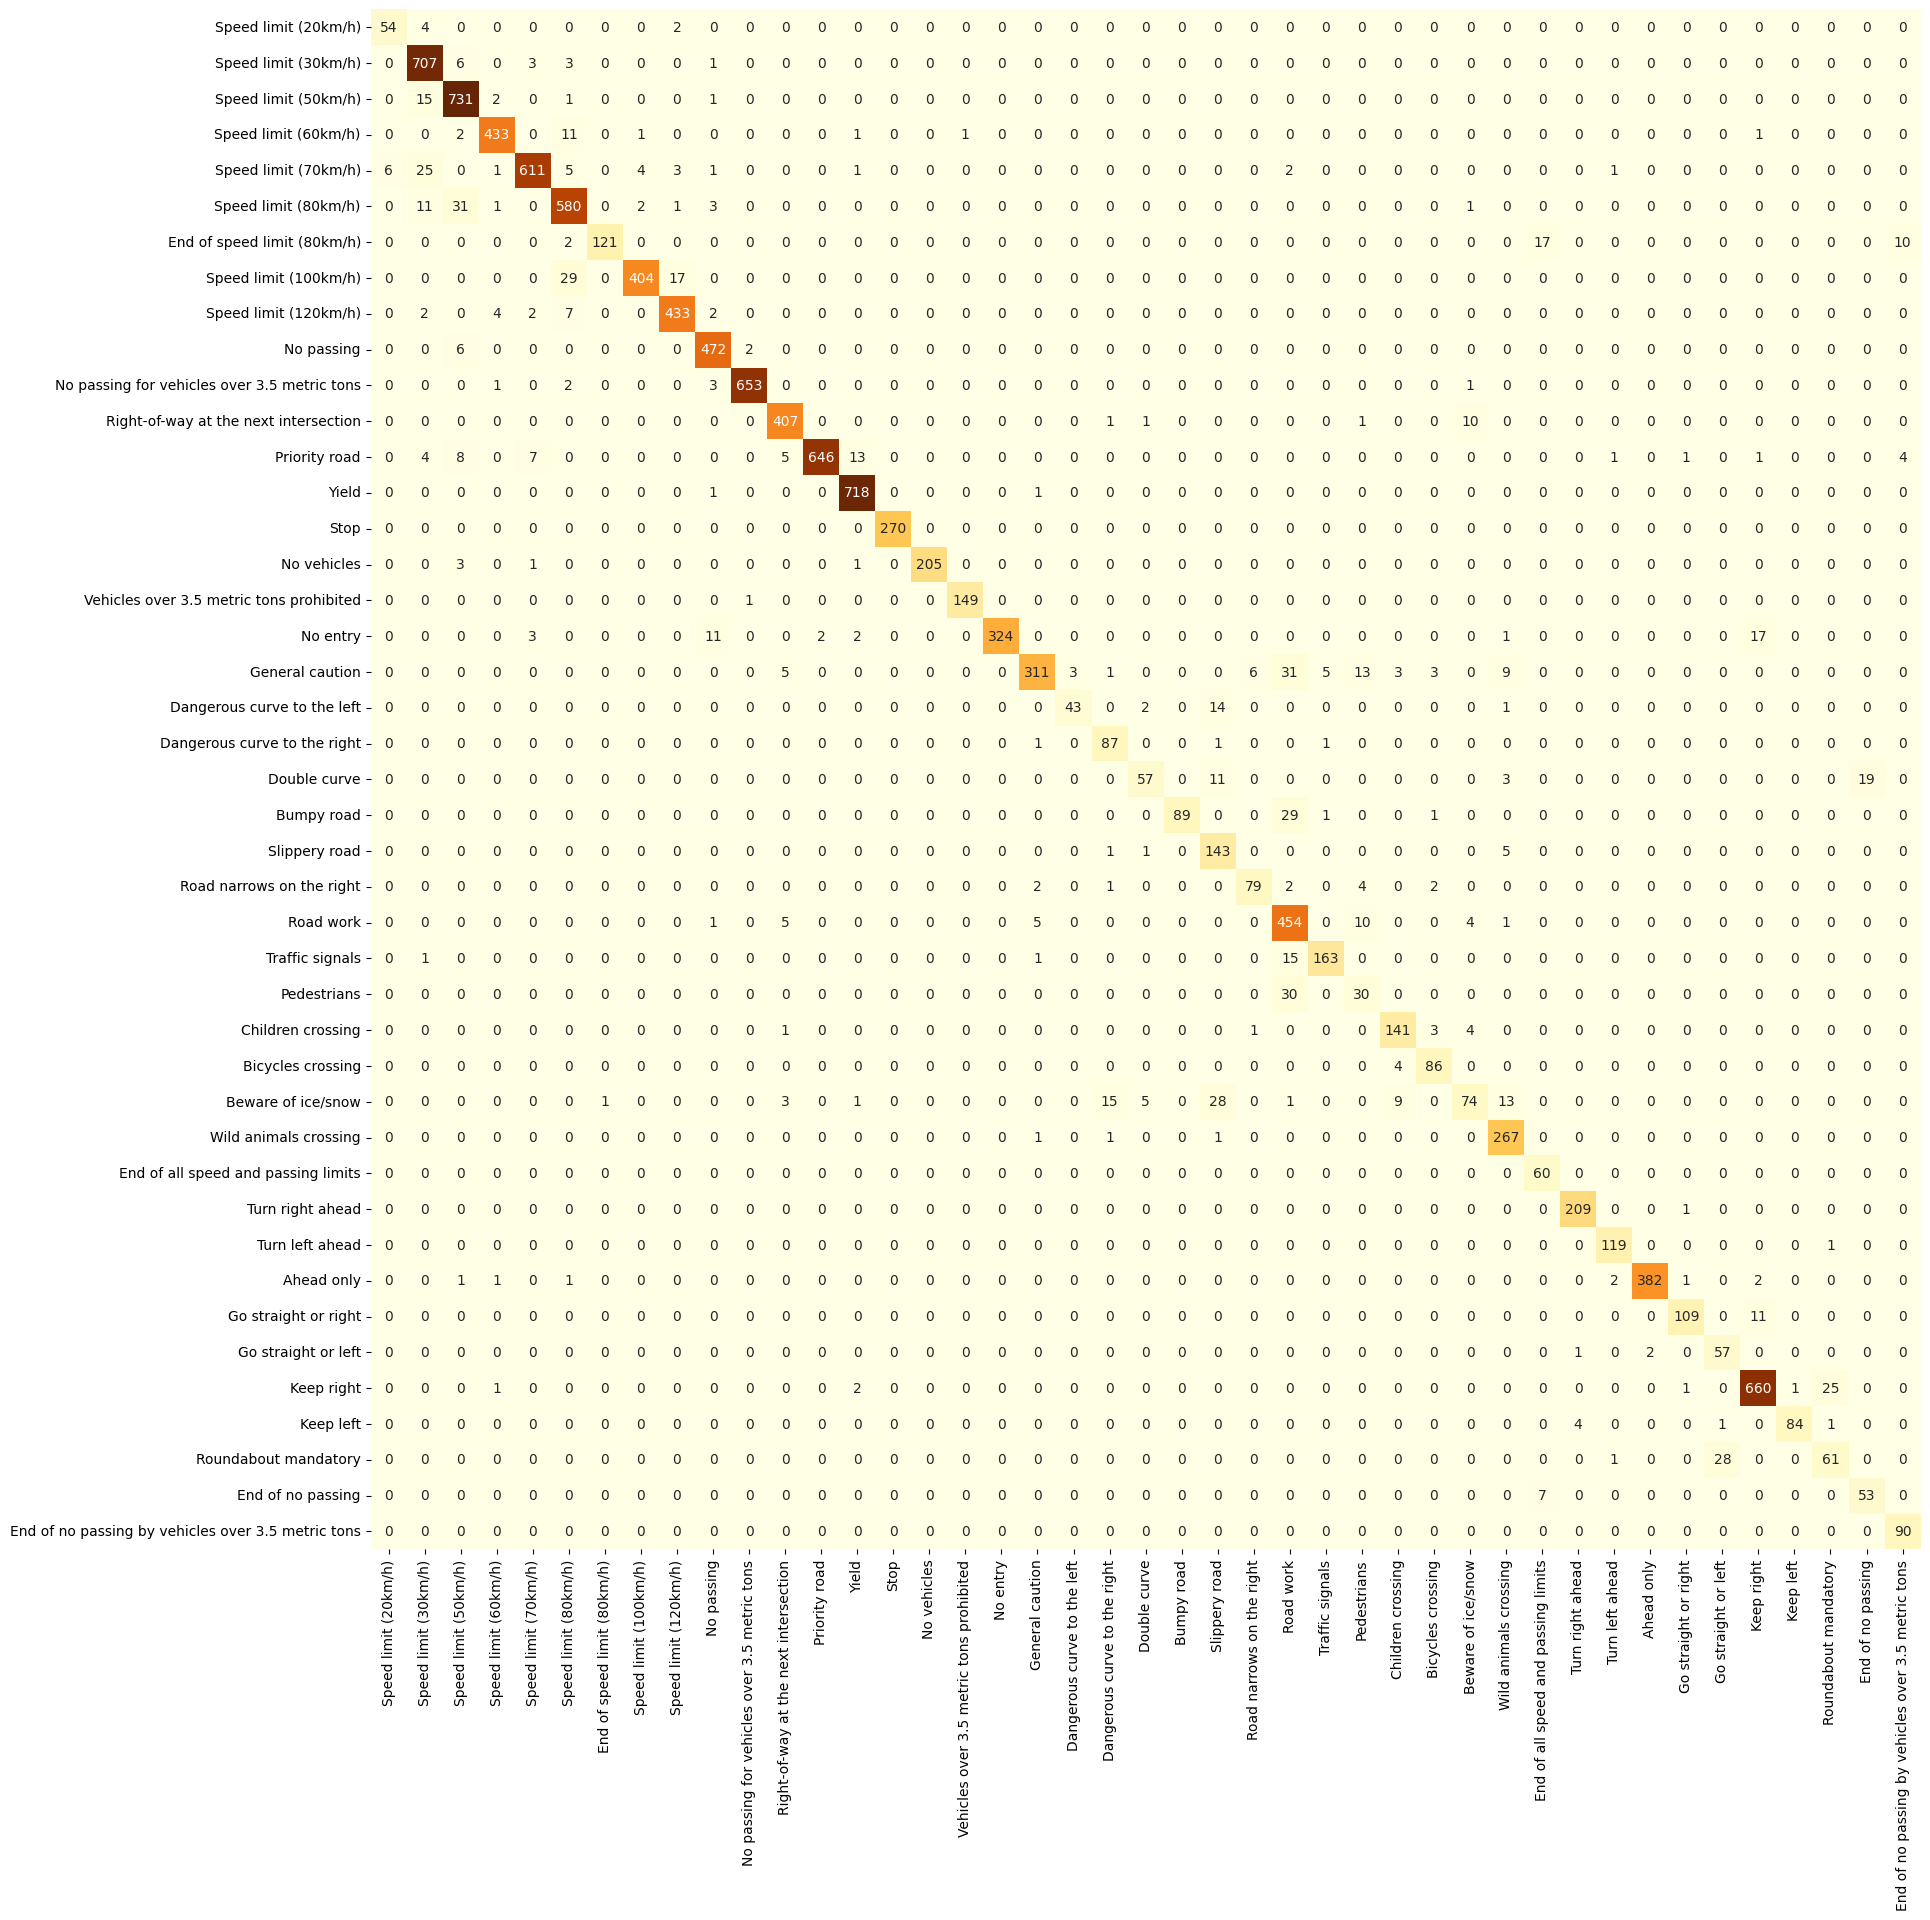

In [107]:
confusion_mat_noaug = confusion_matrix(actual_noaug, predicted_noaug)

plt.figure(figsize = (20,20))
sns.heatmap(confusion_mat_noaug, annot = True, cbar= False, cmap= "YlOrBr", fmt = "d", xticklabels = label_names, yticklabels = label_names)

In [111]:
class_report_incorrect(confusion_mat_noaug, signnames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


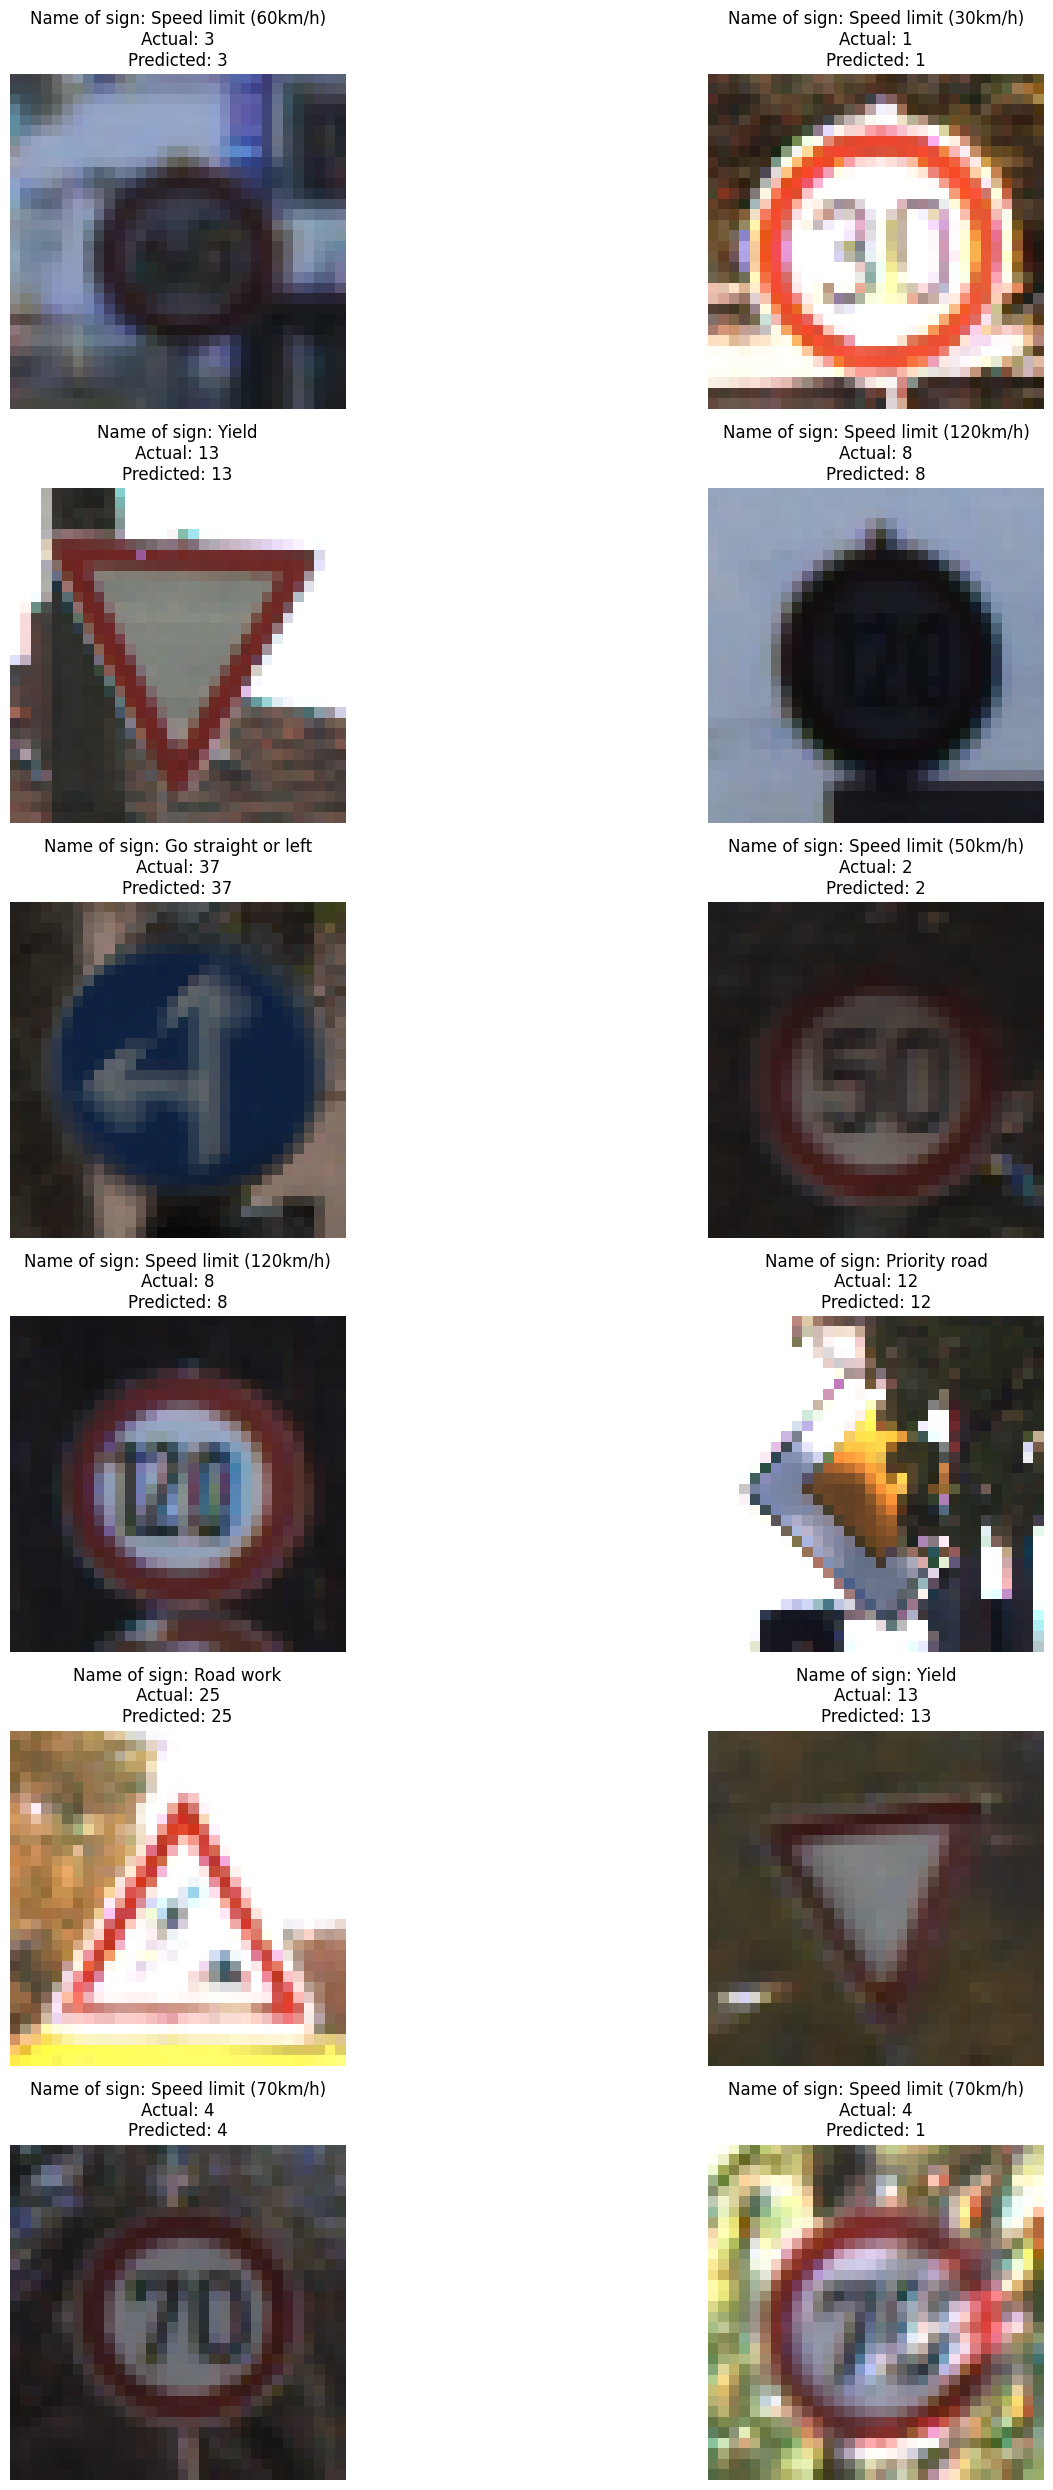

In [123]:
show_signs_output(resnet_modified, signnames, x_test, y_test)

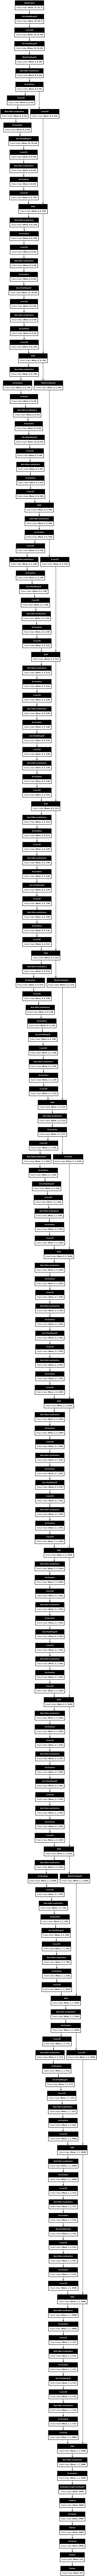

In [132]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(resnet_modified, to_file=dot_img_file, show_shapes=True, dpi=600)

## Pre-trained Model: Resnet50V2
### Weights = None, layers.trainable = True
### Image Augmentation : Yes
### Early stops, dropouts, learning rate scheduler : Yes

In [12]:
image_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
#     tf.keras.layers.RandomBrightness(0.2),
#     tf.keras.layers.RandomContrast(0.2)
])
inputs = tf.keras.Input(shape = (32,32,3))
x = image_augment(inputs)
# x = resnet_base_nda.output
x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = resnet_base_nda(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2048, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation = "relu")(x)
output_layer = tf.keras.layers.Dense(43, activation = "softmax")(x)

resnet_data_aug = tf.keras.models.Model(inputs, outputs = output_layer)

resnet_data_aug.compile(optimizer ="adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [133]:
resnet_data_aug.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 1, 1, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,406,019 (329.61 MB)

 Trainable params: 28,786,859 (109.81 MB)

 Non-trainable params: 45,440 (177.50 KB)

 Optimizer params: 57,573,720 (219.63 MB)

In [13]:
resnet_aug_history = resnet_data_aug.fit(x_train,y_train,epochs=50,validation_data=(x_valid,y_valid),
                                     batch_size = 32, callbacks=[model_check,early_stops,lr_scheduler])

Epoch 1/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 125s 80ms/step - accuracy: 0.1322 - loss: 3.2838 - val_accuracy: 0.3288 - val_loss: 2.2696 - learning_rate: 0.0010
Epoch 2/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 81s 75ms/step - accuracy: 0.4461 - loss: 1.7213 - val_accuracy: 0.5063 - val_loss: 1.6314 - learning_rate: 0.0010
Epoch 3/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.5797 - loss: 1.2946 - val_accuracy: 0.5884 - val_loss: 1.3430 - learning_rate: 0.0010
Epoch 4/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.6697 - loss: 1.0177 - val_accuracy: 0.6528 - val_loss: 1.1183 - learning_rate: 0.0010
Epoch 5/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 82s 75ms/step - accuracy: 0.6756 - loss: 1.0383 - val_accuracy: 0.6728 - val_loss: 1.1618 - learning_rate: 0.0010
Epoch 6/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 83s 76ms/step - accuracy: 0.7814 - loss: 0.6975 - val_accuracy: 0.7354 - val_loss: 0.8841 - learning_rate: 0.0010
Epoch 7/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 79s 73ms/step - accur

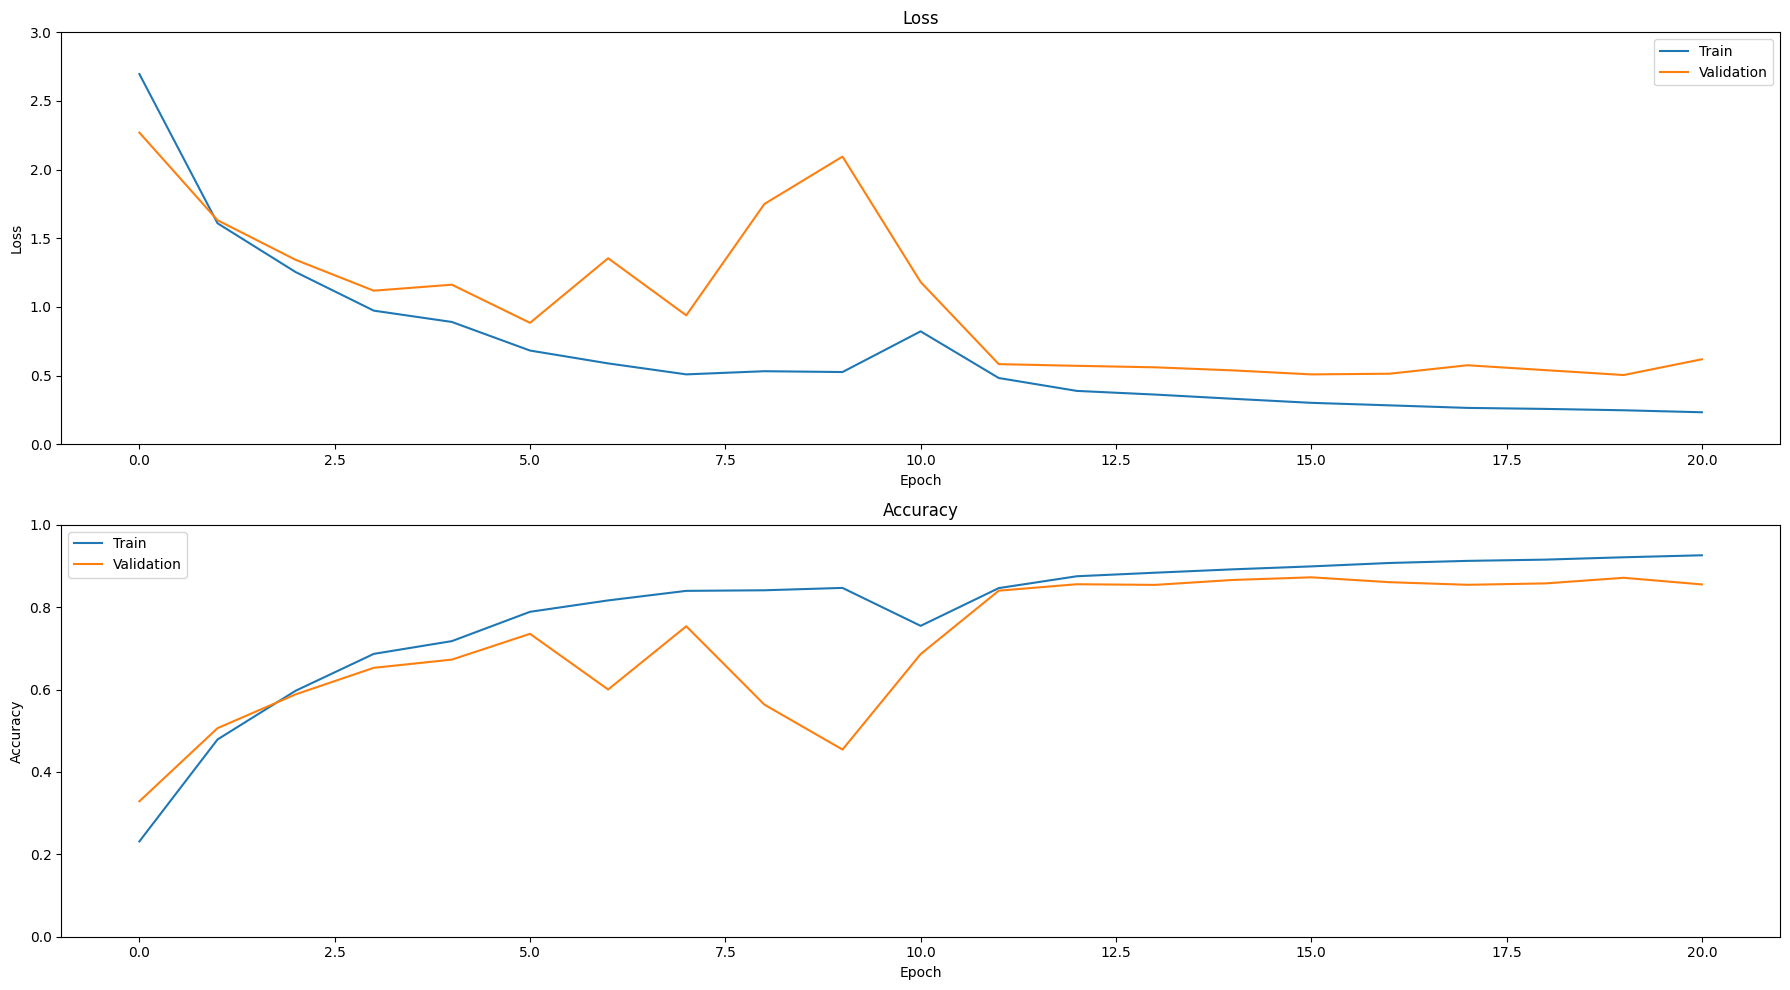

In [20]:
plot_history(resnet_aug_history)

# with image augmentation, the overfitting is diminished with
# the validation loss and accuracy loss stabilizing towards the end
# this is a good model.

In [27]:
#Testing on the augmented data resnet model
actual, predicted = get_actual_labels(x_test,y_test,resnet_data_aug)
label_names = [signnames[i] for i in range(len(signnames))]
class_report = classification_report(actual, predicted, target_names=label_names)
print(class_report)

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.53      0.48      0.50        60
                              Speed limit (30km/h)       0.87      0.89      0.88       720
                              Speed limit (50km/h)       0.83      0.90      0.86       750
                              Speed limit (60km/h)       0.91      0.92      0.91       450
                              Speed limit (70km/h)       0.94      0.94      0.94       660
                              Speed limit (80km/h)       0.76      0.63      0.69       630
                       End of speed limit (80km/h)       0.98      0.83      0.90       150
                             Speed limit (100km/h)       0.80      0.81      0.80       450
                             Speed limit (120km/h)       0.78      0.90      0.84       450
                                      

<Axes: >

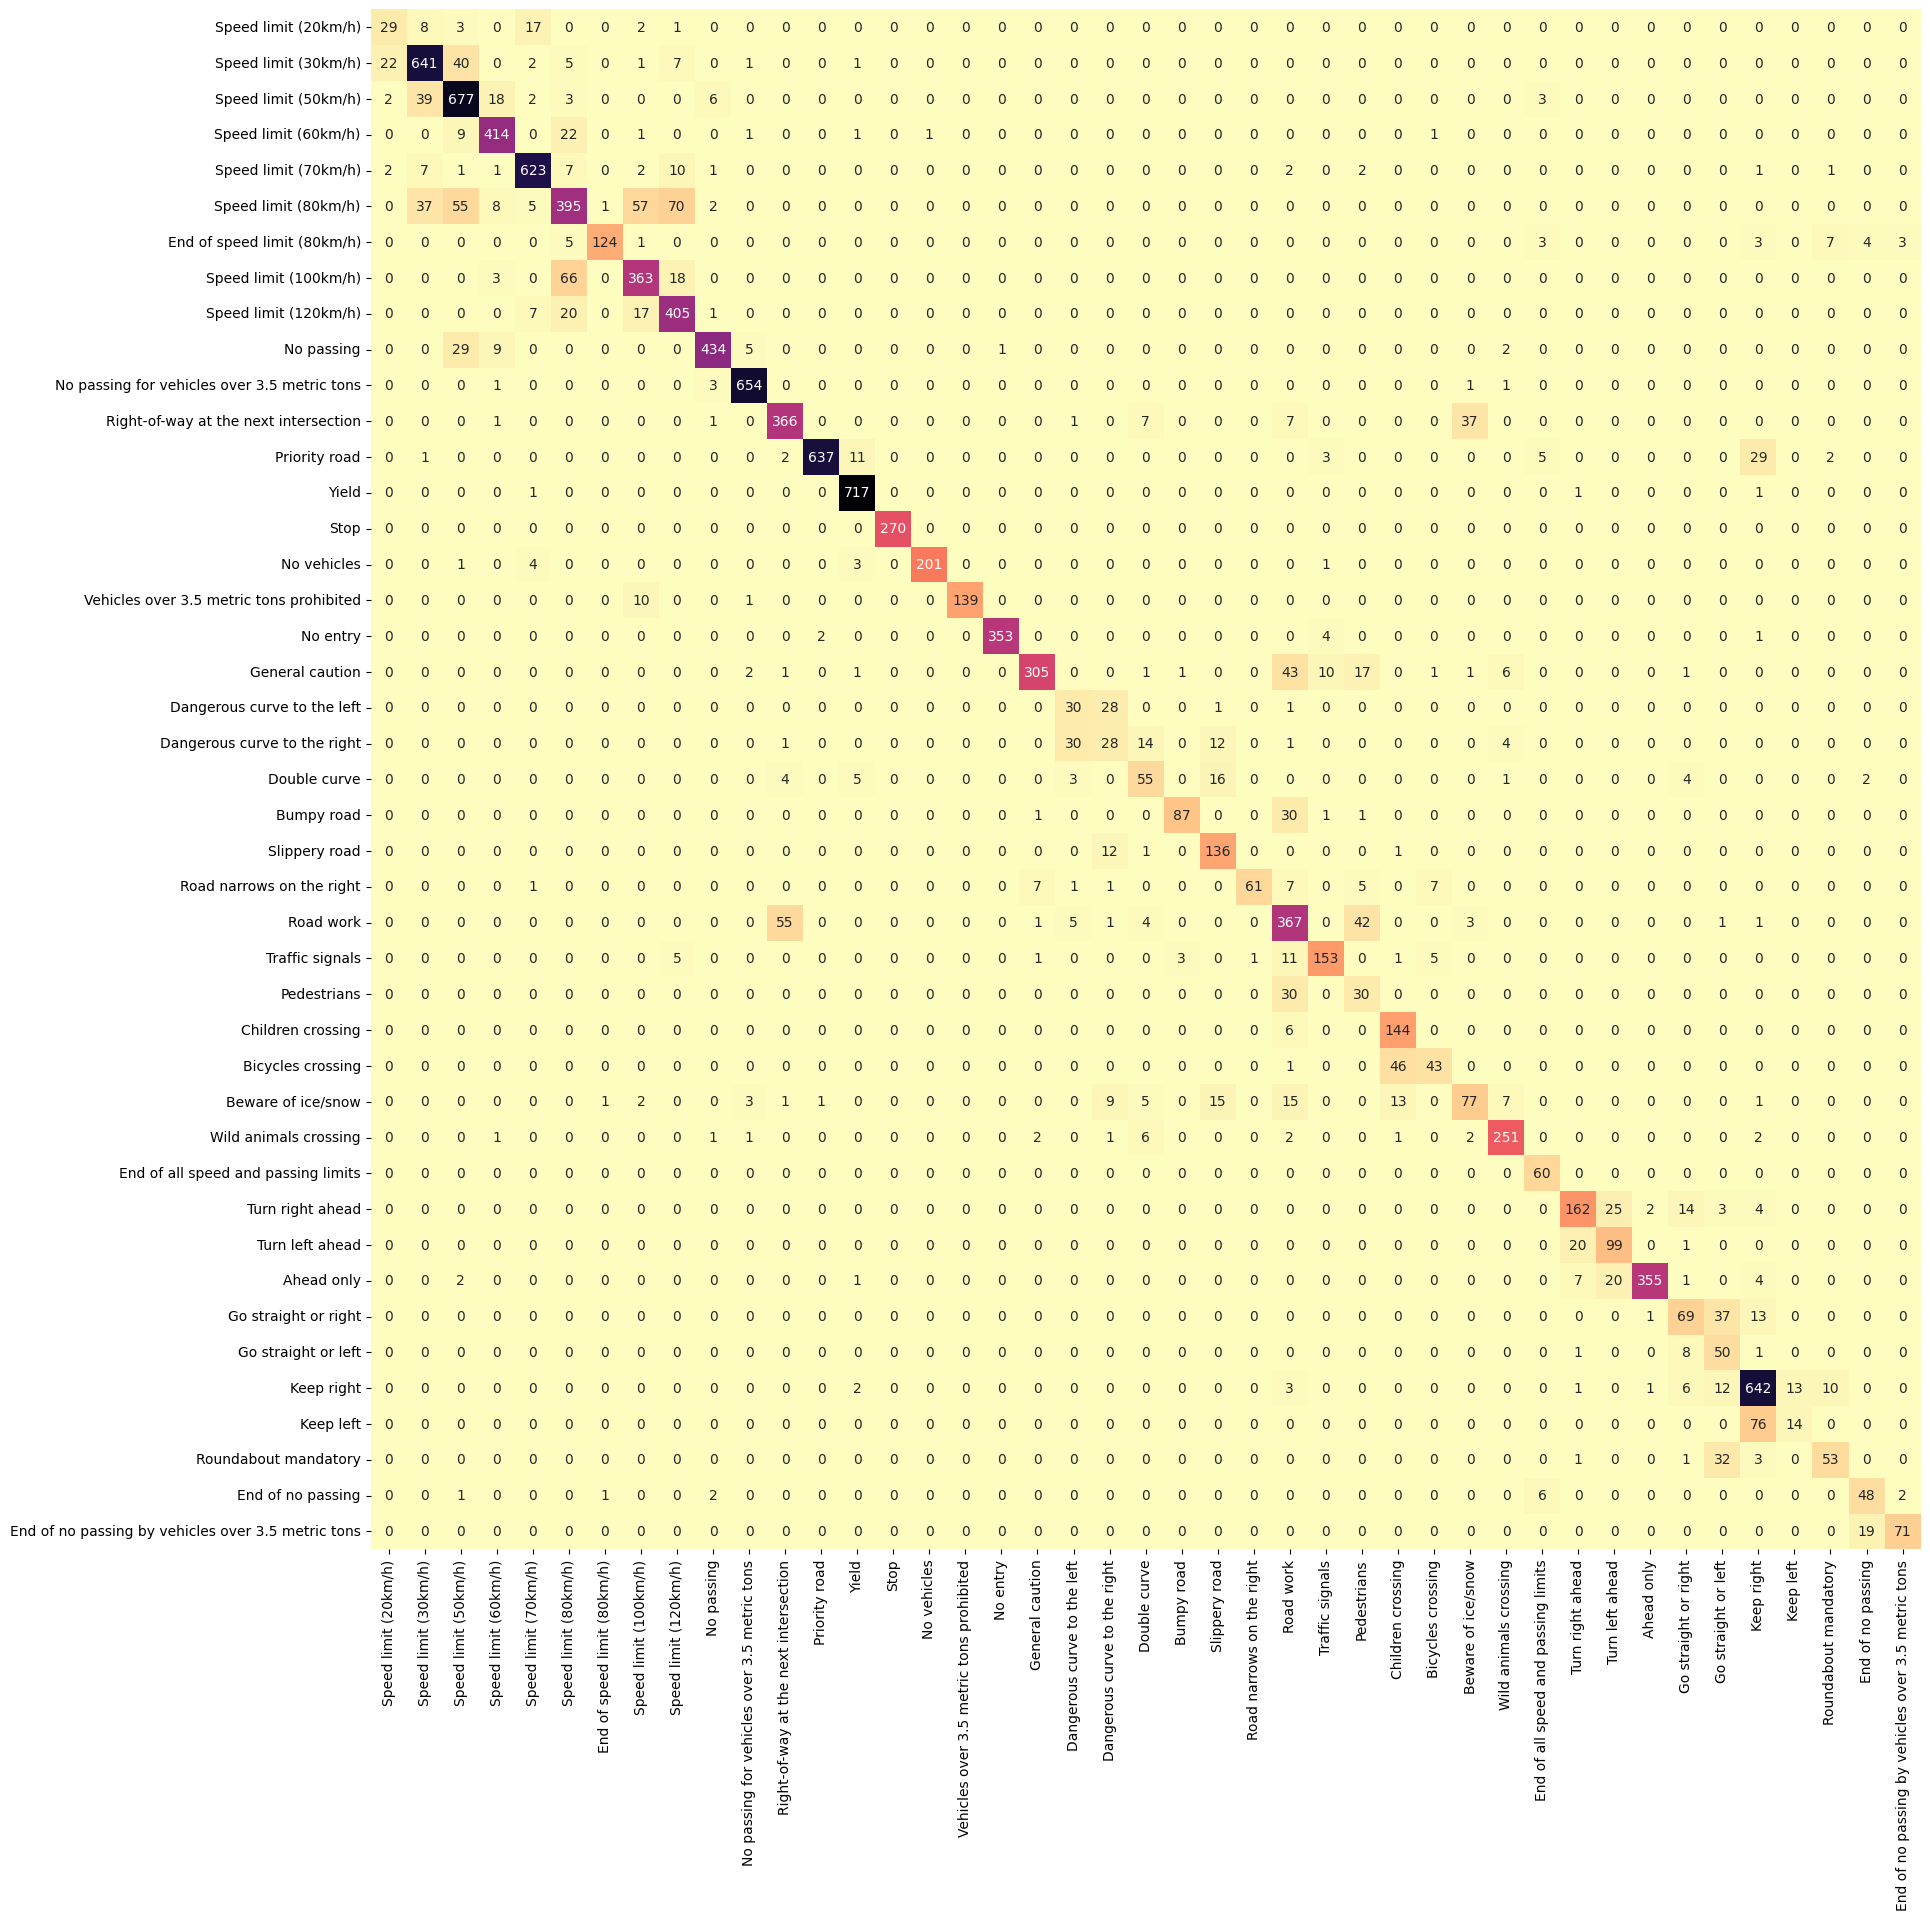

In [45]:
confusion_mat = confusion_matrix(actual, predicted)

plt.figure(figsize = (20,20))
sns.heatmap(confusion_mat, annot = True, cbar= False, cmap= "magma_r", fmt = "d", xticklabels = label_names, yticklabels = label_names)

In [47]:
confusion_mat

array([[ 29,   8,   3, ...,   0,   0,   0],
       [ 22, 641,  40, ...,   0,   0,   0],
       [  2,  39, 677, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  53,   0,   0],
       [  0,   0,   1, ...,   0,  48,   2],
       [  0,   0,   0, ...,   0,  19,  71]])

In [112]:

class_report_incorrect(confusion_mat, signnames)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


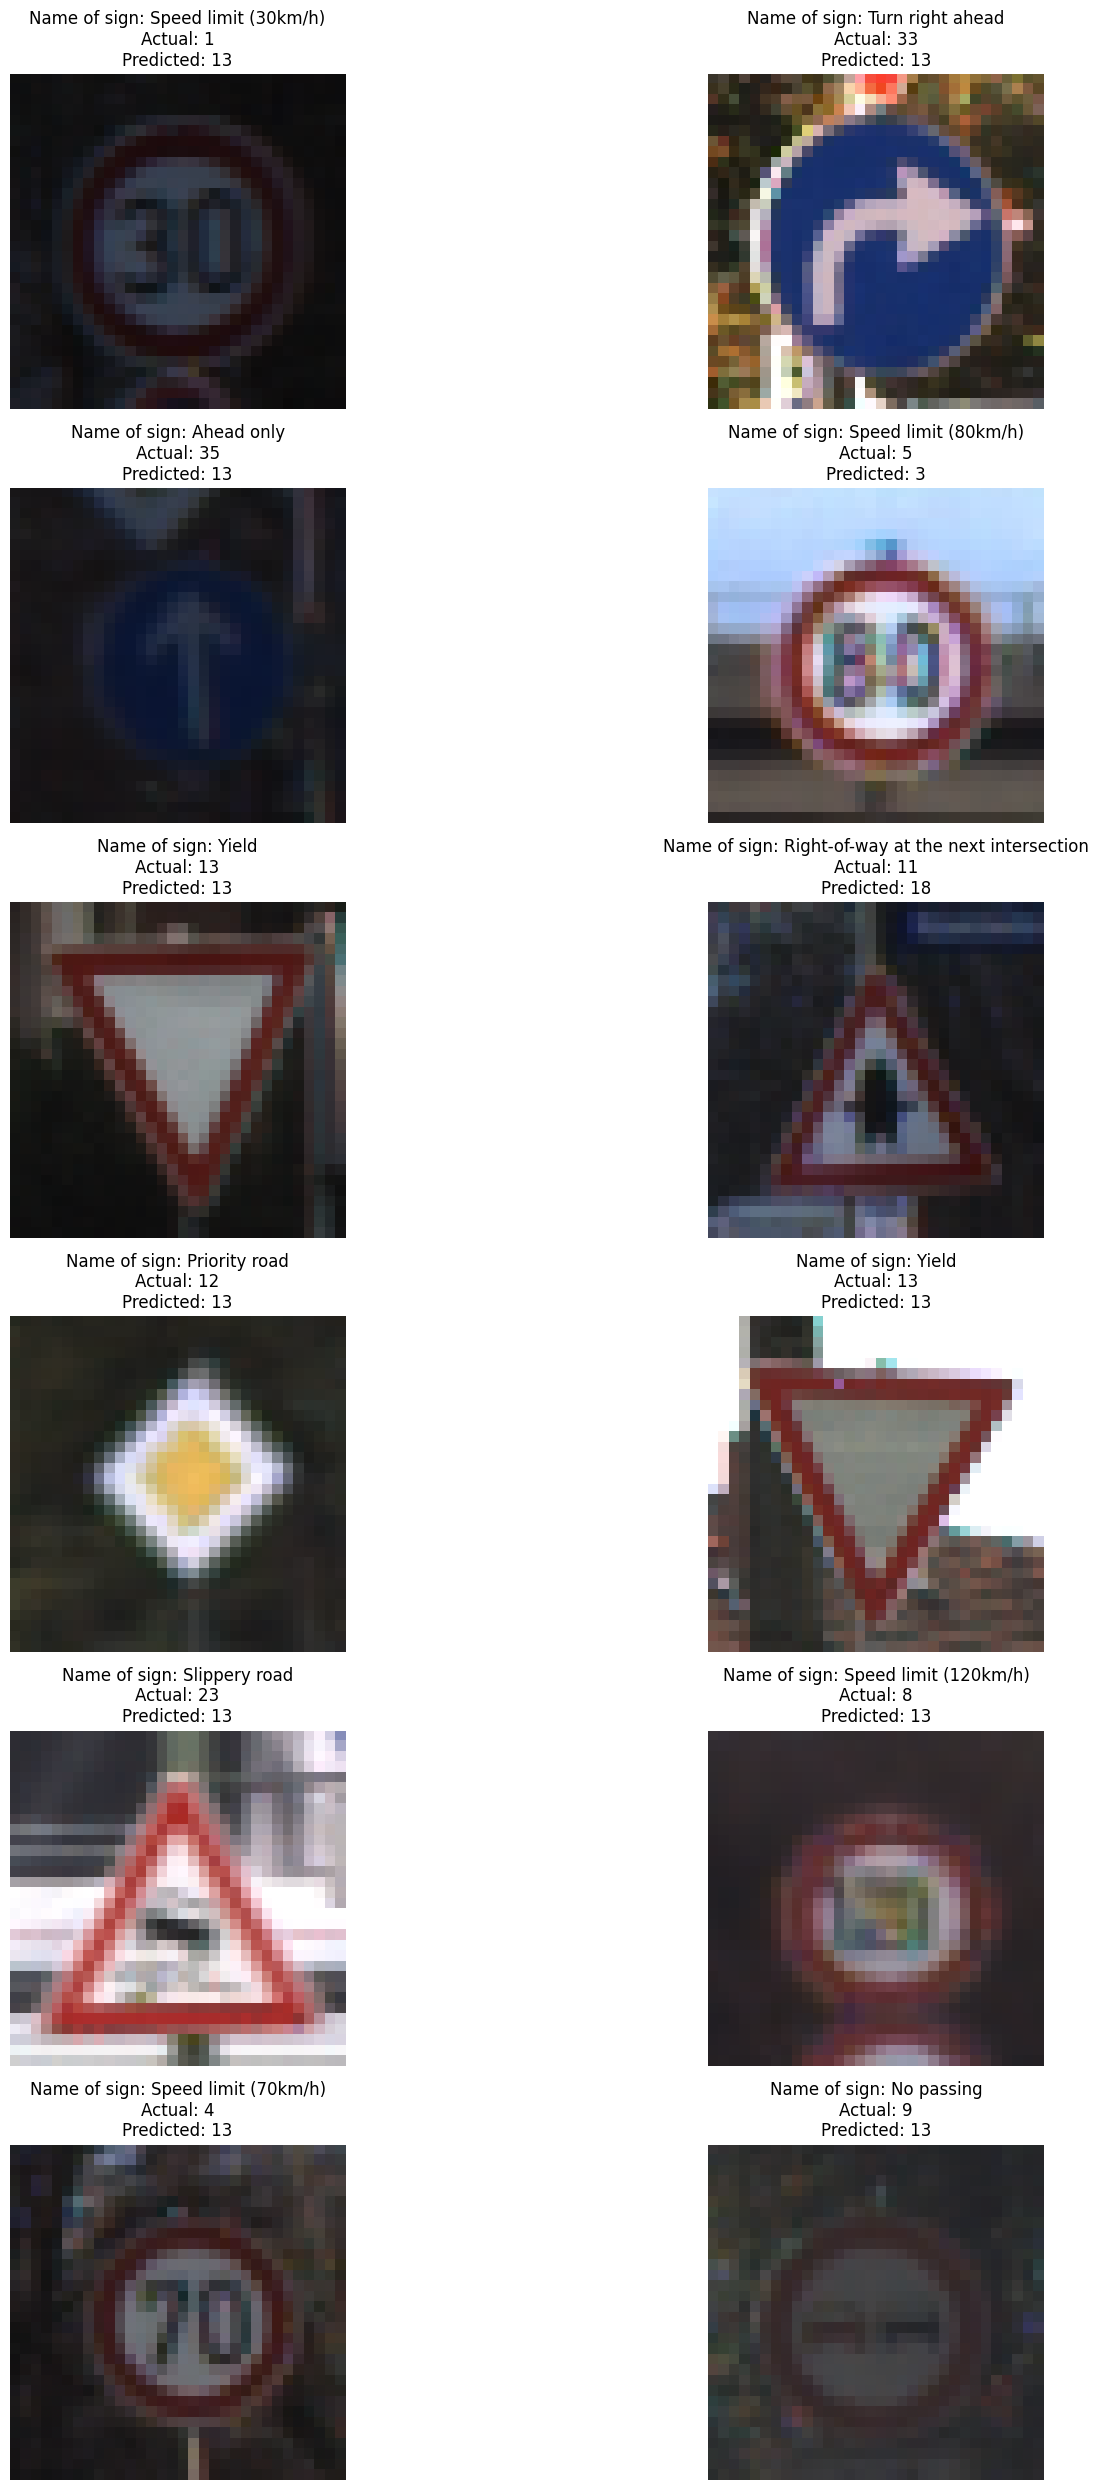

In [115]:
show_signs_output(resnet_data_aug, signnames, x_test, y_test)

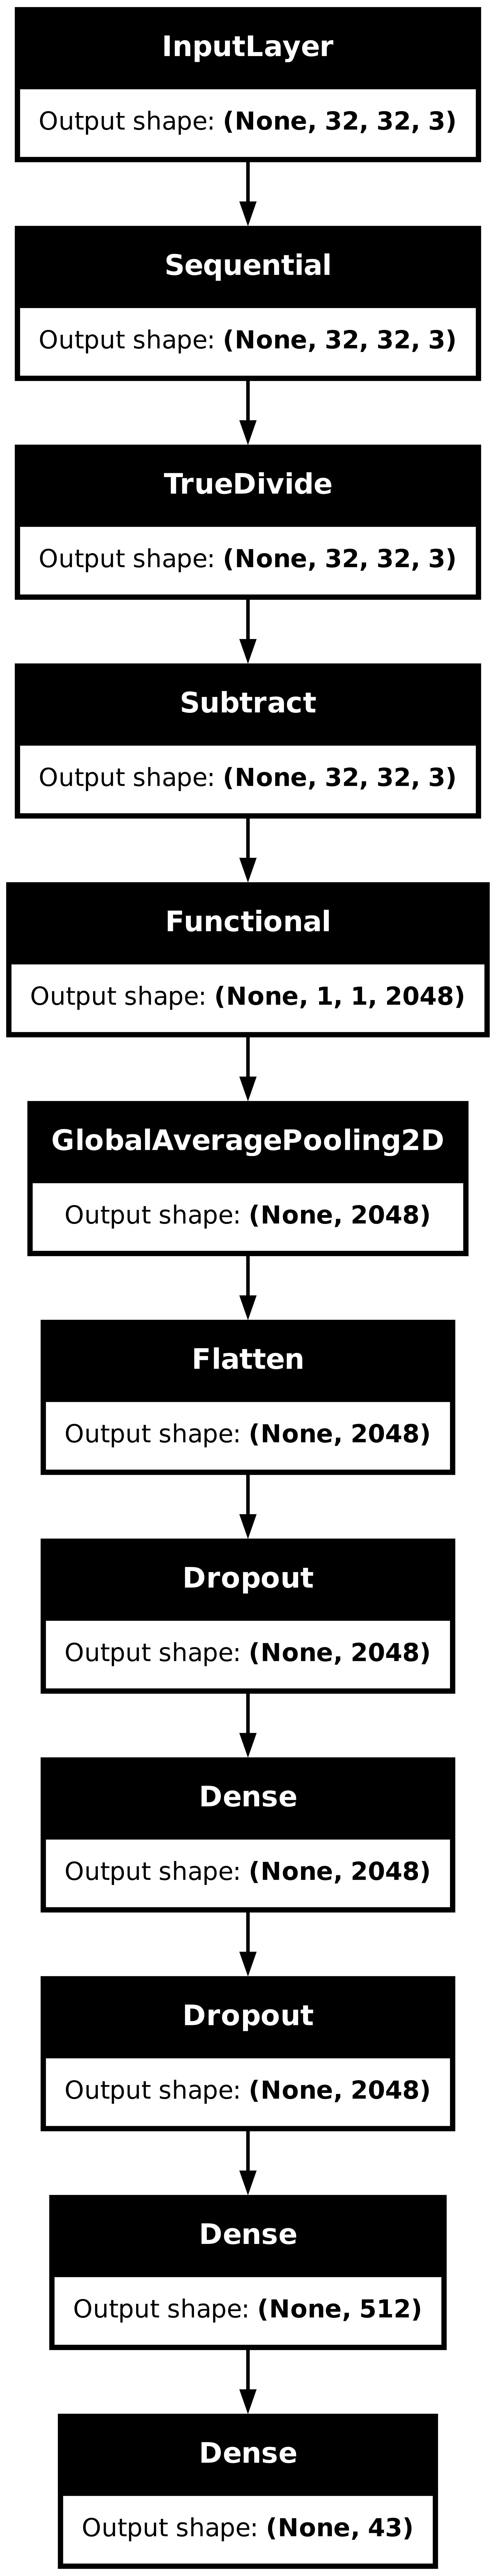

In [131]:
dot_img_file = '/tmp/model_2.png'
tf.keras.utils.plot_model(resnet_data_aug, to_file=dot_img_file, show_shapes=True, dpi=600)